In [7]:
# A scratch cell to run functions directly.
using Reexport
using Distributions
using Statistics
using GeoStats
using Random
using DataFrames
import GLMakie as Mke
using Infiltrator
using AbstractGPs
using Unitful
using Plots
using DataStructures
using POMDPs
include("../src/config.jl");
include("../src/pomdp.jl")
pomdp = CCSPOMDP();


In [8]:
visualize_gt(pomdp, 2)

### Test: Action function returns all actions

In [9]:
all_actions = POMDPs.actions(pomdp);

### Test: Observation function returns correct distributions

Distributions.ProductDistribution{2, 1, Vector{MixtureModel{Multivariate, Distributions.Continuous, MvNormal, Distributions.Categorical{Float64, Vector{Float64}}}}, Distributions.Continuous, Float64}
Reward: 9.1


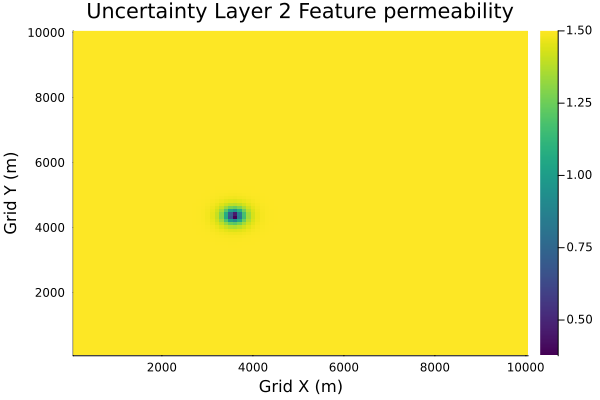

In [10]:
# The high uncertainty decreases once we take a well action
function observe(pomdp::CCSPOMDP, point::Point, layer::Int, column::Symbol, action_id::Symbol)
    # We return a mixture model of the GP conditioned on the rocktype
    obs_conditioned_on_rocktype = Vector{MvNormal}(undef, length(instances(RockType))) # TODO: Replace this Any
    x = pcu(point)
    y = pomdp.state.earth[layer].gt[point, column]
    unc = ACTION_UNCERTAINTY[(action_id, column)]
    
    for rocktype in 1:length(instances(RockType))
        if pomdp.rocktype_belief[layer].p[rocktype] == 0.0
        end
        # TODO: Add a short circuit when rocktype has probability 0
        f = pomdp.belief[rocktype][layer][column]
        if unc < 0 # Feature belief not changed by action
            mean_cond = mean(f(x))
            cov_cond = cov(f(x))
        else
            p_fx = posterior(f(x, unc), y)
            pomdp.belief[rocktype][layer][column] = p_fx
            
            mean_cond = mean(p_fx(x))
            cov_cond = cov(p_fx(x))
        end
        obs_conditioned_on_rocktype[rocktype] = MvNormal(mean_cond, cov_cond)
    end
    return Distributions.MixtureModel(obs_conditioned_on_rocktype, pomdp.rocktype_belief[layer].p)
end

function POMDPs.observation(pomdp::CCSPOMDP, action, state)
    component_distributions::Vector{MixtureModel{Multivariate, Distributions.Continuous, MvNormal, Distributions.Categorical{Float64, Vector{Float64}}}} = []
    for layer in 1:NUM_LAYERS
        if action.id == :well_action # an observation with action_id == :well_action determines rock type
            rocktype = pomdp.state.earth[layer].layer_rocktype
            upd_prob = zeros(length(instances(RockType)))
            upd_prob[Int(rocktype)] = 1.0
            pomdp.rocktype_belief[layer] = Distributions.Categorical(upd_prob)
        end
        for feature in pomdp.feature_names
            push!(component_distributions, observe(pomdp, action.geometry, layer, feature, action.id))
        end
    end

    return product_distribution(component_distributions)
end

distr = POMDPs.observation(pomdp, all_actions[2], pomdp.state)
reward = POMDPs.reward(pomdp, pomdp.state, all_actions[2])
println(typeof(distr), "\nReward: ", reward)

function visualize_uncertainty(pomdp::CCSPOMDP, layer::Int, column::Symbol)
    stds_mtx = zeros(GRID_SIZE, GRID_SIZE)
    gridx = pcu([pt.vertices[1] for pt in domain(pomdp.state.earth[layer].gt)]) 
    for rocktype in 1:length(instances(RockType))
        if pomdp.rocktype_belief[layer].p[rocktype] == 0.0
            continue
        end
        ms = marginals(pomdp.belief[rocktype][layer][column](gridx))
        mg_stds = std.(ms) * sqrt(pomdp.rocktype_belief[layer].p[rocktype])
        # for (i, pt) in enumerate([pt.vertices[1] for pt in domain(pomdp.state.earth[layer].gt)])
        #     if ustrip(pt - all_actions[2].geometry) < 200 && (mg_stds[i] < 1.49)
        #         print("$pt : $(mg_stds[i])\n")
        #     end
        # end
        stds_mtx .+= reshape(mg_stds, GRID_SIZE, GRID_SIZE)'
    end

    xaxisvalues = yaxisvalues = (1:GRID_SIZE) .* SPACING
    heatmap(xaxisvalues, 
            yaxisvalues,
            stds_mtx, 
            color=:viridis, 
            xlabel="Grid X (m)", 
            ylabel="Grid Y (m)", 
            title="Uncertainty Layer $layer Feature $column",
            # clims=(0, maximum(mg_stds))
            )
end

visualize_uncertainty(pomdp, 2, :permeability)

  0.102617 seconds (987.94 k allocations: 50.070 MiB, 26.06% gc time, 58.20% compilation time: 10% of which was recompilation)
  0.236152 seconds (4.30 M allocations: 278.820 MiB, 12.16% gc time)
Distributions.ProductDistribution{2, 1, Vector{MixtureModel{Multivariate, Distributions.Continuous, MvNormal, Distributions.Categorical{Float64, Vector{Float64}}}}, Distributions.Continuous, Float64}Reward: 376764.847136591


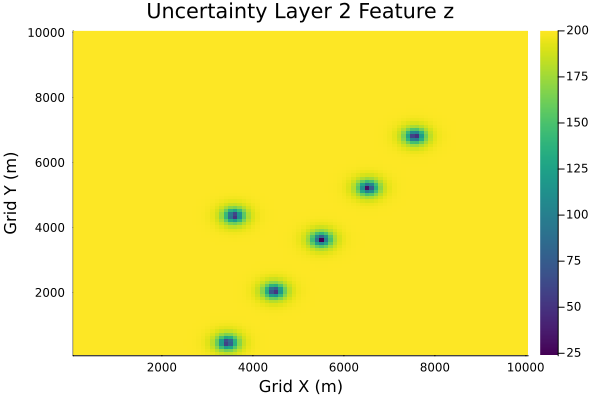

In [11]:
# Timing test for seismic line observation and reward function
@time distr = POMDPs.observation(pomdp, all_actions[19], pomdp.state)
@time reward = POMDPs.reward(pomdp, pomdp.state, all_actions[19])
println(typeof(distr), "Reward: ", reward)
visualize_uncertainty(pomdp, 2, :z)

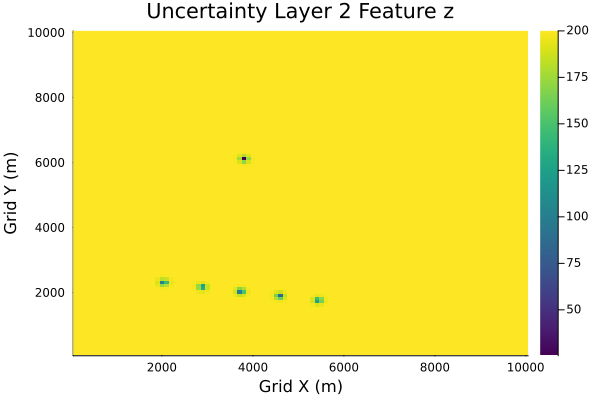

In [19]:
# Timing test for well log observation and reward function
@time distr = POMDPs.observation(pomdp, all_actions[2], pomdp.state)
@time reward = POMDPs.reward(pomdp, pomdp.state, all_actions[2])
println(typeof(distr), "Reward: ", reward)
visualize_uncertainty(pomdp, 2, :z)